# 1 Part

In [1]:
from melbanks import LogMelFilterBanks
import torch
import torchaudio

In [2]:
signal, sr = torchaudio.load("/home/darinka/Downloads/My Little Black Angel Death In June.wav")

In [3]:
melspec = torchaudio.transforms.MelSpectrogram(
    hop_length=160,
    n_mels=80
)(signal)
logmelbanks = LogMelFilterBanks()(signal)
log_melspec = torch.log(melspec + 1e-6)

assert log_melspec.shape == logmelbanks.shape
assert torch.allclose(log_melspec, logmelbanks)

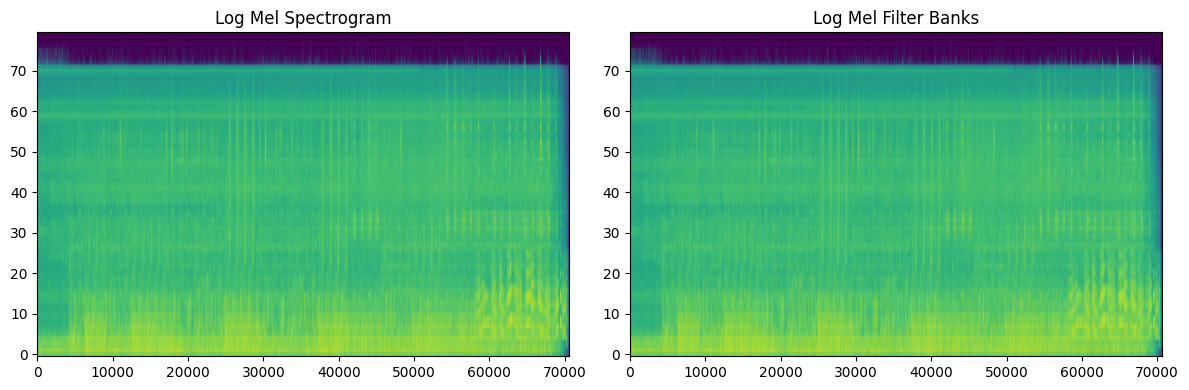

In [4]:
import matplotlib.pyplot as plt

log_melspec_np = log_melspec[0].cpu().numpy()
logmelbanks_np = logmelbanks[0].cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(log_melspec_np, origin="lower", aspect="auto")
axs[0].set_title("Log Mel Spectrogram")

axs[1].imshow(logmelbanks_np, origin="lower", aspect="auto")
axs[1].set_title("Log Mel Filter Banks")

plt.tight_layout()
plt.show()

# 2 Part

In [1]:
from cnn import BinarySpeechCommands, SpeechCommandBinaryClassifier, collate_fn
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from lightning.pytorch.loggers import WandbLogger
import wandb

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = BinarySpeechCommands(subset="training")
val_dataset = BinarySpeechCommands(subset="validation")
test_dataset = BinarySpeechCommands(subset="testing")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [7]:
model = SpeechCommandBinaryClassifier(lr=1e-3)

In [8]:
wandb_logger = WandbLogger(
    name="hw1_part1",
    project="Speech_homework",
    log_model="all"
)
trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)
wandb.finish()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: darinka to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 10.9 K | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:17<00:00, 14.48it/s, v_num=i2bh, val_loss=0.0316, val_acc=0.988]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:17<00:00, 14.13it/s, v_num=i2bh, val_loss=0.0316, val_acc=0.988]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1782720.0   MACs: 891360.0   Params: 10898.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:01, 13.04it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_

# Part 3

In [9]:
n_melss = [20, 40, 80]

for n_mels in n_melss:
    model = SpeechCommandBinaryClassifier(n_mels=n_mels, lr=1e-3)
    wandb_logger = WandbLogger(
        name=f"hw1_part2_cnn-n_mels={n_mels}",
        project="Speech_homework",
        log_model="all"
    )
    trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, test_loader)
    wandb.finish()

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 619200.0   MACs: 309600.0   Params: 5138.0 




  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 5.1 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:12<00:00, 20.04it/s, v_num=pqtq, val_loss=0.0341, val_acc=0.990]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:12<00:00, 19.30it/s, v_num=pqtq, val_loss=0.0341, val_acc=0.990]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 619200.0   MACs: 309600.0   Params: 5138.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:00, 40.78it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_av

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1007040.0   MACs: 503520.0   Params: 7058.0 




  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 7.1 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:18<00:00, 13.74it/s, v_num=gjlg, val_loss=0.0245, val_acc=0.993]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:18<00:00, 13.43it/s, v_num=gjlg, val_loss=0.0245, val_acc=0.993]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1007040.0   MACs: 503520.0   Params: 7058.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:01, 17.84it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_a

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1782720.0   MACs: 891360.0   Params: 10898.0 




  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 10.9 K | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.47it/s, v_num=1207, val_loss=0.0217, val_acc=0.993]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 17.91it/s, v_num=1207, val_loss=0.0217, val_acc=0.993]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1782720.0   MACs: 891360.0   Params: 10898.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:01, 16.36it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_

# Part 3

In [3]:
groups = [2, 4, 8, 16]
n_mels_best = 80

for group in groups:
    model = SpeechCommandBinaryClassifier(n_mels=n_mels_best, lr=1e-3, groups=group)
    wandb_logger = WandbLogger(
        name=f"hw1_part3_cnn-n_mels={n_mels_best}_groups={group}",
        project="Speech_homework",
        log_model="all"
    )
    trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, test_loader)
    wandb.finish()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: darinka to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 5.5 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:20<00:00, 12.27it/s, v_num=ty9g, val_loss=0.039, val_acc=0.986] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:28<00:00,  8.68it/s, v_num=ty9g, val_loss=0.039, val_acc=0.986]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 891840.0   MACs: 445920.0   Params: 5522.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:03,  6.31it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_av

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 2.8 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:12<00:00, 20.54it/s, v_num=wtr1, val_loss=0.0439, val_acc=0.981]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:12<00:00, 19.60it/s, v_num=wtr1, val_loss=0.0439, val_acc=0.981]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 446400.0   MACs: 223200.0   Params: 2834.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:01, 12.96it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_av

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 1.5 K  | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 19.16it/s, v_num=eqqj, val_loss=0.0865, val_acc=0.968]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.25it/s, v_num=eqqj, val_loss=0.0865, val_acc=0.968]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 223680.0   MACs: 111840.0   Params: 1490.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:01, 21.88it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_av

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | feature_extractor | LogMelFilterBanks | 0      | train
1 | cnn               | CNN               | 818    | train
2 | criterion         | CrossEntropyLoss  | 0      | train
----------------------------------------------------------------
818       Trainable params
0         Non-trainable params
818       Total params
0.003     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 250/250 [00:12<00:00, 19.61it/s, v_num=jlnr, val_loss=0.220, val_acc=0.910]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:13<00:00, 18.82it/s, v_num=jlnr, val_loss=0.220, val_acc=0.910]

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0:   0%|          | 0/26 [00:00<?, ?it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 112320.0   MACs: 56160.0   Params: 818.0 

Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:01, 22.16it/s][INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgp